## Final Notebook - Hotel Customer Review Analysis

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import wrangle
import unicodedata
from nltk.corpus import stopwords

plt.rc('figure', figsize=(10, 7))
plt.style.use('fivethirtyeight')

### Project Overview:

- As the data science team at Booking.com we analyzed the extensive customer review dataset for our partner hotels in the European region. Using natural language processing, sentiment analysis, and topic modeling we were able to identify key word and key topic drivers of reviewer’s score. Using reviewer’s scores we calculated current Promoter Scores for each hotel helping them understand their customer’s opinions so they can implement improvements based on the insight from our review analysis. 


### Project Goals:

- To analyze customer review data and provide insight to Booking.com for their partner hotels. Looking at who the primary customer groups are, how they are scoring our hotels, what they have to say and what topics are driving high versus low scores.

### Data Acquisition:

- The dataset was collected from kaggle where said data was scraped from Booking.com. This dataset contains 515,738 customer reviews and scoring of 1493 luxury hotels across Europe with positive and negative reviews along with other columns that contain features for exploration. A data dictionary can be found within the README.md.


### Data Wrangling:

- This project required extensive data cleaning and wrangling including:

    - changing the column names to all lower case
    
    - parsing the list of strings in the tags column into separate feature columns
    
    - changing the data type of the timestamp column and engineering additional features containing portions of the overall time stamp
    
    - verifying and updating review word counts
    
    - parsing the address values and creating separate features for country, city, etc.
    
    - dropping unneeded columns
    
    - preparing the text data from NLP including basic clean, removing stopwords, and lemmatizing
    
    - changing the order of the columns within the dataframe 
    
    - cache the wrangled data as a json to reduce processing time during exploration

- All functions for data cleaning and wrangling can be found in the wrangle.py file included in the repository

In [2]:
# Pull in the cleaned and wrangled dataset using the wrangle_hotel function
df = wrangle.wrangle_hotel()


In [3]:
# Fill coordinate null values with median coordinates corresponding to each city
df = wrangle.fill_coord_nulls(df)
# Show dataframe information
df.info()
# View the first three rows of the dataframe
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 41 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   review_date                                 515738 non-null  datetime64[ns]
 1   month_name                                  515738 non-null  object        
 2   month                                       515738 non-null  int64         
 3   year                                        515738 non-null  int64         
 4   day_name                                    515738 non-null  object        
 5   day                                         515738 non-null  int64         
 6   quarter                                     515738 non-null  int64         
 7   hotel_name                                  515738 non-null  object        
 8   street                                      515738 non-null  object       

,review_date,month_name,month,year,day_name,day,quarter,hotel_name,street,city,...,review_total_positive_word_counts,positive_unique_word_count,pos_lem_sentiment_score,positive_topic,negative_review,negative_clean_review,negative_lemma,positive_review,positive_clean_review,positive_lemma
0,2015-08-04,August,8,2015,Tuesday,4,3,Hilton London Metropole,225 Edgware Road Westminster Borough,London,...,8,6,0.4019,location,First day the swimming pool was not opened th...,first day swimming pool opened therefore could...,first day swimming pool opened therefore could...,The hotel was clean and accessible,hotel clean accessible,hotel clean accessible
1,2015-08-04,August,8,2015,Tuesday,4,3,Hotel Mademoiselle,7 Rue des Petits H tels 10th,Paris,...,7,6,0.7906,location,No Negative,,,very good location breakfast was great,good location breakfast great,good location breakfast great
2,2015-08-04,August,8,2015,Tuesday,4,3,Vienna Marriott Hotel,Parkring 12a 01 Innere Stadt,Vienna,...,7,6,0.7579,hotel,Nothing,,,It was very nice excellent hotel,nice excellent hotel,nice excellent hotel


---

### Exploration - Who are our Customers?

- The initial exploration of the dataset consisted of reviewing the distribution of customers across key groupings including trip type, group type and nights stayed as well as looking at reviewer score distributions and average hotel score distributions

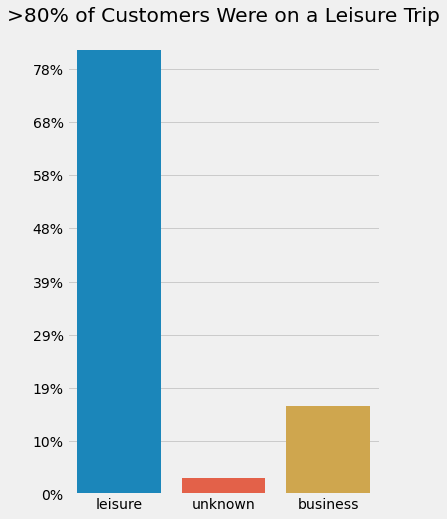

In [4]:
import matplotlib.ticker as mtick
# #visualize the count of customers by trip type

plt.figure(figsize=(5,8))
ax = sns.countplot(x='trip_type', data=df)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df), decimals=None))
plt.xlabel('')
plt.ylabel('')
#plt.xticks([])
plt.title('>80% of Customers Were on a Leisure Trip')
plt.show()

#### Key Takeaways:

Looking at the chart above 81% of the the customers who gave a review were on a leisure trip. Leaving ~20% of the customers who gave a review to be on a buisness trip or other. Understanding the purpose of the customers stay can help the hotel cater to the needs of the customer who is most likley to give a review. 

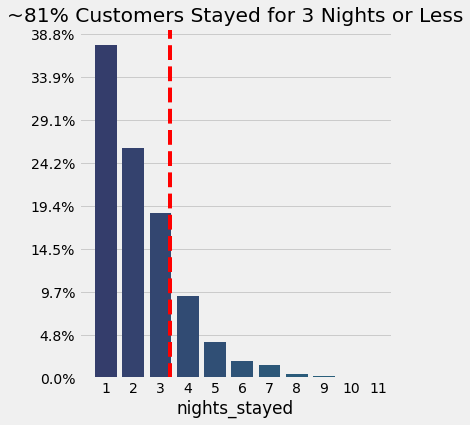

In [10]:
plt.figure(figsize=(5,6))
# Change color of bars
# Visualize the number of customers by number of nights stayed
ax = sns.countplot(x='nights_stayed', data=df, palette='crest_r')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df), decimals=None))
plt.title('~81% Customers Stayed for 3 Nights or Less')
plt.xlim(-1, 10.5)
# add labels
#plt.xlabel('')
# Line of average nights stayed
plt.axvline(df.nights_stayed.mean(), ls='--', color='r')
plt.ylabel('')
plt.show()

Key Takeaways:

- 37.5% of customers stayed one night
- 25.9% of customers stayed two nights
- 18.5% of customers stayed three nights
- 9.2% of customers stayed four nights
- 8.9% of customers stayed over four nights


~ 81% of the customers who gave a review stayed at a hotel for less than three nights. This gives the hotel approximately three nights to improve the majority of customers experience for an increase in review score.

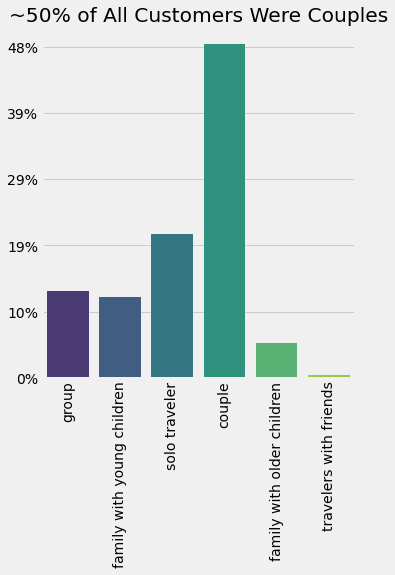

In [6]:
#visualize the number of customers by group type
plt.figure(figsize=(5,6))
ax = sns.countplot(x='group_type', data=df, palette='viridis')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df), decimals=None))
plt.xticks(rotation=90)
plt.title('~50% of All Customers Were Couples')
plt.xlabel('')
plt.ylabel('')
plt.show()

Key Takeaways:
- 48.9% of customers who gave a review were a couple.
- 21% of customers who gave a review were solo travelers.
- 12.6% of customers who gave a review were a group.
- 11.8% of customers who gave a review were a family with young children.


The majority of customers who gave a review were couples at 48.9% of all reviews. Followed by solo travelers at 21% of all reviews. 69.9% of all reviews were in parties of two people or less. With ~ 30% of customers who gave a review in a party greater than two people.

---

## Exploration - What is the distribution of reviewer scores?

The distribution of reviewer scores indicates a tendency toward score inflation.

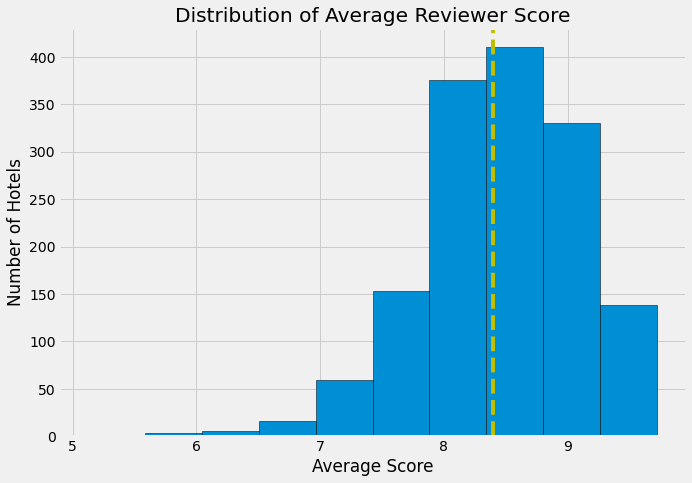

In [9]:
#visualize the distribution of average reviewer score
df.groupby('hotel_name').reviewer_score.mean().plot.hist(ec= 'black')
plt.title('Distribution of Average Reviewer Score')
plt.xlabel('Average Score')
plt.ylabel('Number of Hotels')
# add average score line
plt.axvline(df.reviewer_score.mean(), ls='--', color='y')
plt.show()

Key Takeaways:

The distribution of the reviewer score is skewed to the left with an average reviewer score of 8.4. The lowest average reviewer score is 5.12 and the highest average reviewer score is 9.73.


In [7]:
#summary stats for reviewer scores
df.reviewer_score.describe()

count    515738.000000
mean          8.395077
std           1.637856
min           2.500000
25%           7.500000
50%           8.800000
75%           9.600000
max          10.000000
Name: reviewer_score, dtype: float64

In [8]:
def hotel_data():
    """Function takes in a Hotel Name 
    and returns the rolling average of the 
    reviewer score and the number of reviews.
    """
    # combine the 'month', 'year', and 'day' columns into a single column called 'date'
    df['date'] = df['month'].astype(str) + '/' + df['day'].astype(str) + '/' + df['year'].astype(str)
    # create datetime with date column
    df['date'] = pd.to_datetime(df['date'])
    # set date as datetime index
    df.set_index('date', inplace=True)
    # hotel_name = 'Intercontinental London The O2'
    # hotel_df = df[df.hotel_name == hotel_name]
    hotel_df = df.resample('W').mean().assign(
    rolling_30=lambda df: df.reviewer_score.rolling(4).mean(),
    rolling_60=lambda df: df.reviewer_score.rolling(8).mean(),
    rolling_90=lambda df: df.reviewer_score.rolling(12).mean(),
    )
    # create one plot for all three rolling averages
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    ax.plot(hotel_df.rolling_30, label='30-day rolling average')
    ax.plot(hotel_df.rolling_60, label='60-day rolling average')
    ax.plot(hotel_df.rolling_90, label='90-day rolling average')
    ax.set_title('Rolling Averages of Reviewer Score')
    ax.set_ylabel('reviewer score')
    ax.lines[0].set_linewidth(4)
    ax.lines[1].set_linewidth(4)
    ax.lines[2].set_linewidth(4)
    for label in ax.xaxis.get_ticklabels():
        label.set_fontsize(15)
    ax.tick_params(axis='x', rotation=30)
    ax.legend()
    # add average score line
    ax.axhline(y=df.reviewer_score.mean(), color='black', linestyle='--', linewidth=4)
    plt.show()

    # create a plot for the rolling average of number of reviews
    hotel_df = df.resample('W').mean().assign(
    rolling_30=lambda df: df.total_number_of_reviews.rolling(4).mean(),
    rolling_60=lambda df: df.total_number_of_reviews.rolling(8).mean(),
    rolling_90=lambda df: df.total_number_of_reviews.rolling(12).mean(),
    )
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    ax.plot(hotel_df.rolling_30, label='30-day rolling average')
    ax.plot(hotel_df.rolling_60, label='60-day rolling average')
    ax.plot(hotel_df.rolling_90, label='90-day rolling average')
    ax.set_title('Rolling Averages of Total Number of Reviews')
    ax.set_ylabel('Total number of reviews')
    ax.lines[0].set_linewidth(4)
    ax.lines[1].set_linewidth(4)
    ax.lines[2].set_linewidth(4)
    for label in ax.xaxis.get_ticklabels():
        label.set_fontsize(15)
    ax.tick_params(axis='x', rotation=30)
    # add average total number of reviews line
    ax.axhline(y=df.total_number_of_reviews.mean(), color='black', linestyle='--', linewidth=4)
    ax.legend()
    plt.show()
    return

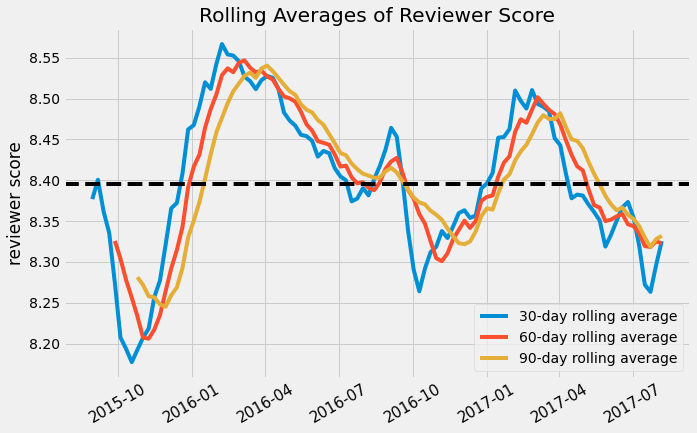

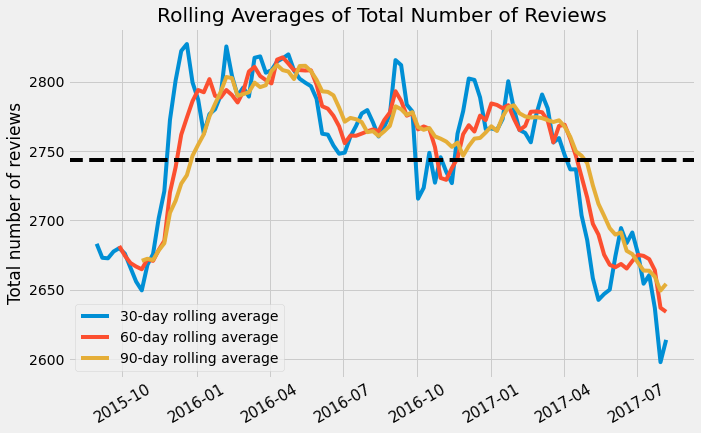

In [9]:
hotel_data()

In [11]:
# average number of hotel reviews
print(f'Average Number of Hotel Reviews: {round(df.total_number_of_reviews.mean())}')


Average Number of Hotel Reviews: 2744


Key Takeaways:

The data shows that between July to December(end of the year/Holiday season) guest tend to score hotels lower then average. Where between January to June guest tend to score hotels higher then average. There is a slight decline in customer reviews as the year progresses.

---

### Exploration - Promoter Scores:

- Promoter scores use reviewer's scores between 0 and 10 to classify each reviewer as either a '*detractor*' ($score<7$), a '*passive*' ($7<score<9$), or a '*promoter*' ($score>9$).

- The promoter score for a hotel is calculated by taking the number of promoters minus the number of detractors divided by the total number of reviewers

In [12]:
def hotel_nps_score(series):
    '''
    This function takes in a series from the nps_group column and calculates the promoter score by
    taking the count of promoters minus the count of detractors and dividing it by the total number
    of reviewers
    '''
    #assign a variable for calculating the promoter score
    score = ((series == 'promoter').sum() - (series == 'detractor').sum()) / series.size
    score = round(score * 100)
    return score

In [13]:
#calculate promoter scores for each hotel
hotel_df = pd.DataFrame(df.groupby(df.hotel_name).nps_group.apply(hotel_nps_score))
#rename the resulting score column as 'promoter score'
hotel_df = hotel_df.rename(columns={'nps_group':'promoter_score'})
#sort the values in decending order and show the truncated results
hotel_df.sort_values(by='promoter_score', ascending=False)

,promoter_score
hotel_name,
H10 Casa Mimosa 4 Sup,93
Ritz Paris,93
Hotel Casa Camper,93
The Soho Hotel,92
Bulgari Hotel London,92
...,...
Villa Eugenie,-52
Kube Hotel Ice Bar,-53
Savoy Hotel Amsterdam,-56


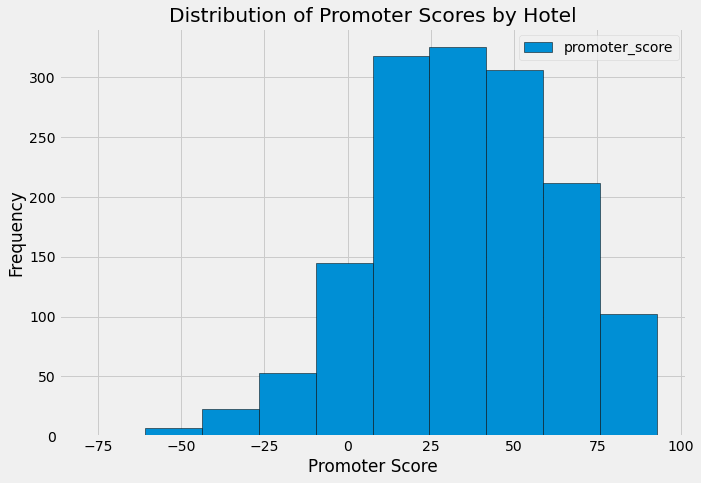

In [14]:
#Distribution of hotel promoter scores
hotel_df.plot.hist(ec='black')
plt.title('Distribution of Promoter Scores by Hotel')
plt.xlabel('Promoter Score')
plt.show()

Key Takeaways:

The average promoter score is 34.
The minimum promoter score is -78.
The maximum promoter score is 93. 

The promoter score is a method we used to gauge the hotels' customer service performance more accurately than the raw reviewer score or an average of the raw reviewer score. The raw reviewer score showed a tendency toward inflation.

In [15]:
# promoter score summary statistics in hotel_df
hotel_df.promoter_score.describe()

count    1492.000000
mean       34.391421
std        27.524849
min       -78.000000
25%        16.000000
50%        35.000000
75%        55.000000
max        93.000000
Name: promoter_score, dtype: float64

---

## Exploration - Natural Language Processing

- After cleaning / wrangling the text data from the reviews we looked at most frequent unigrams, bigrams, trigrams, etc from both the positive reviews and the negative reviews. 

In [16]:
#join all the positive review text into one string
pos_reviews = ' '.join(df.positive_clean_review)
#split the string on whitespaces so word count/comparisons can be made
pos_reviews = pos_reviews.split()
#join all the negative review text into one string
neg_reviews = ' '.join(df.negative_clean_review) 
#split the string on whitespaces so word count/comparisons can be made
neg_reviews = neg_reviews.split()

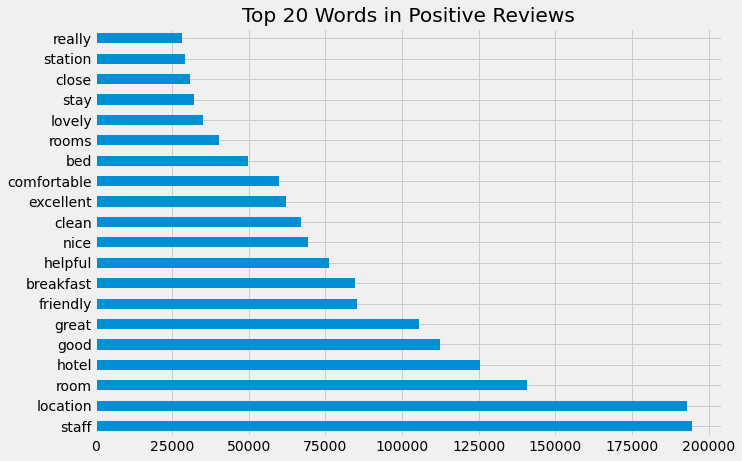

In [17]:
#visualize the top 20 unigrams in the positive reviews
pd.Series(pos_reviews).value_counts().head(20).plot.barh()
plt.title('Top 20 Words in Positive Reviews')
plt.show()

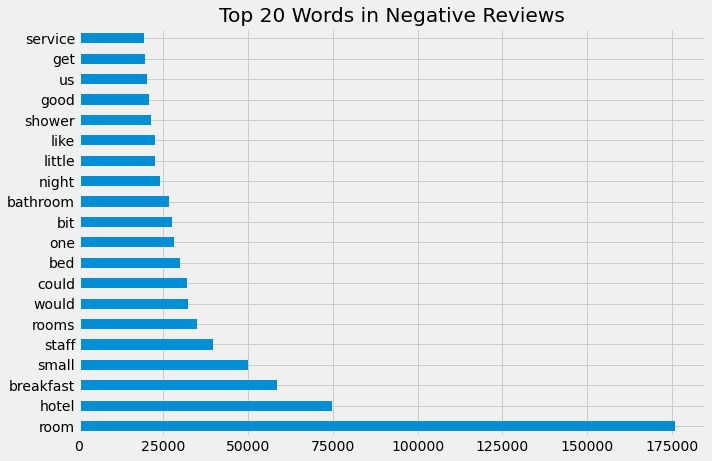

In [18]:
#visualize the top 20 words in the negative reviews
pd.Series(neg_reviews).value_counts().head(20).plot.barh()
plt.title('Top 20 Words in Negative Reviews')
plt.show()

Text(0.5, 1.0, 'Top 20 Bigrams in Positive Reviews')

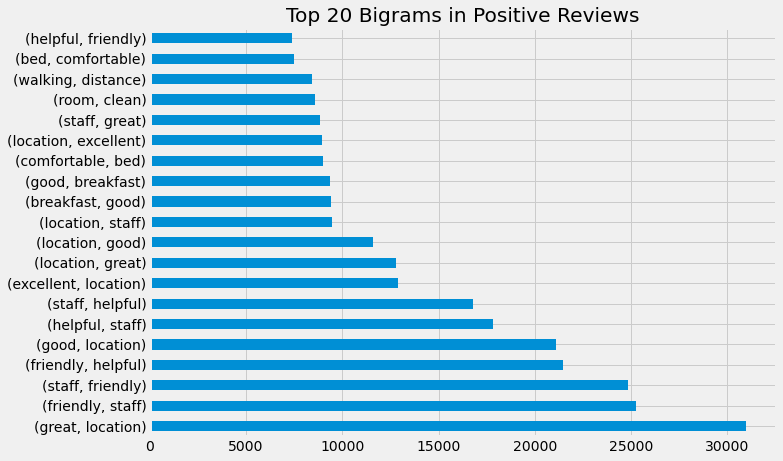

In [19]:
#top 20 positive review bigrams
pos_bigrams = (pd.Series(nltk.ngrams(pos_reviews, 2)).value_counts().head(20))
pos_bigrams.plot.barh()
plt.title('Top 20 Bigrams in Positive Reviews')

Text(0.5, 1.0, 'Top 20 Bigrams in Negative Reviews')

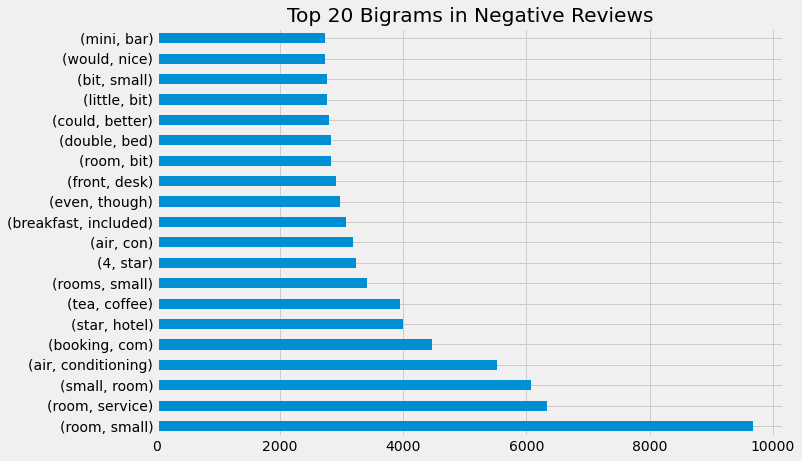

In [19]:
#top 20 negative review bigrams
neg_bigrams = (pd.Series(nltk.ngrams(neg_reviews, 2)).value_counts().head(20))
neg_bigrams.plot.barh()
plt.title('Top 20 Bigrams in Negative Reviews')

Text(0.5, 1.0, 'Top 20 Tetragrams in Positive Reviews')

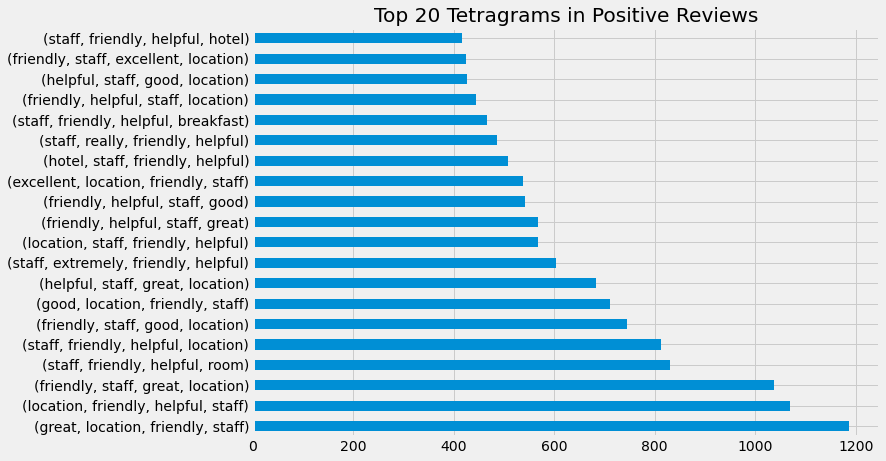

In [20]:
#top 20 positive review n-grams = 4
pos_quadgrams = (pd.Series(nltk.ngrams(pos_reviews, 4)).value_counts().head(20))
pos_quadgrams.plot.barh()
plt.title('Top 20 Tetragrams in Positive Reviews')

Text(0.5, 1.0, 'Top 20 Tetragrams in Negative Reviews')

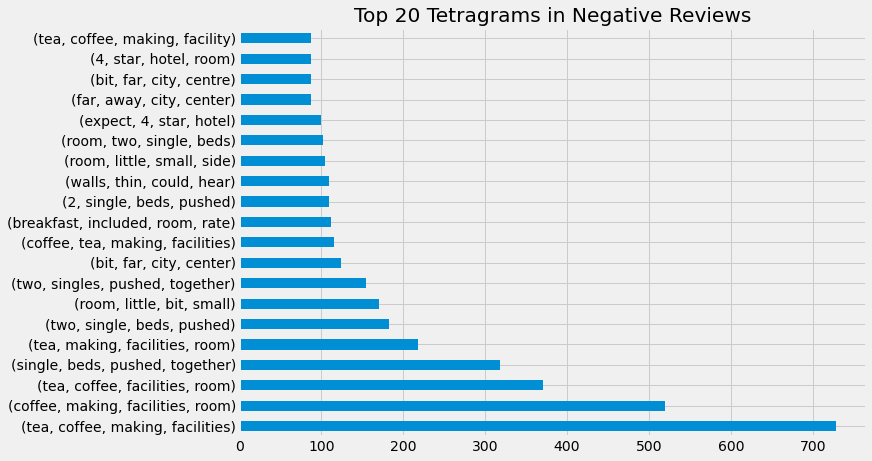

In [21]:
#top 20 negative review n-grams = 4
neg_quadgrams = (pd.Series(nltk.ngrams(neg_reviews, 4)).value_counts().head(20))
neg_quadgrams.plot.barh()
plt.title('Top 20 Tetragrams in Negative Reviews')

---

## Sentiment Intensity Analysis

#### Sentiment Intensity scores are, in essence, calculated by the use of a comparison to a dictionary of positive and negative words. 
The scores range from -1 to 1, where -1 is the most negative, and 1 is the most positive.

- Notable trends were found in the average sentiment intensity scores for trip type ('leisure', 'business', 'unknown') and group type ('couple', 'solo traveler', 'group', 'family with young children', 'family with older children', 'travelers with friends').
- Leisure travelers' average sentiment intensity scores were higher than those of the other two trip types.
- Solo travelers and families with young children tended to have lower average sentiment intensity scores than the other groups.
- Sentiment scores for negative reviews were muted in comparison to scores for positive reviews.
- Among the Promoter Score groups ('Detractor', 'Passive', 'Promoter'), Detractors had a clear, negative polarity on negative SIA scores.


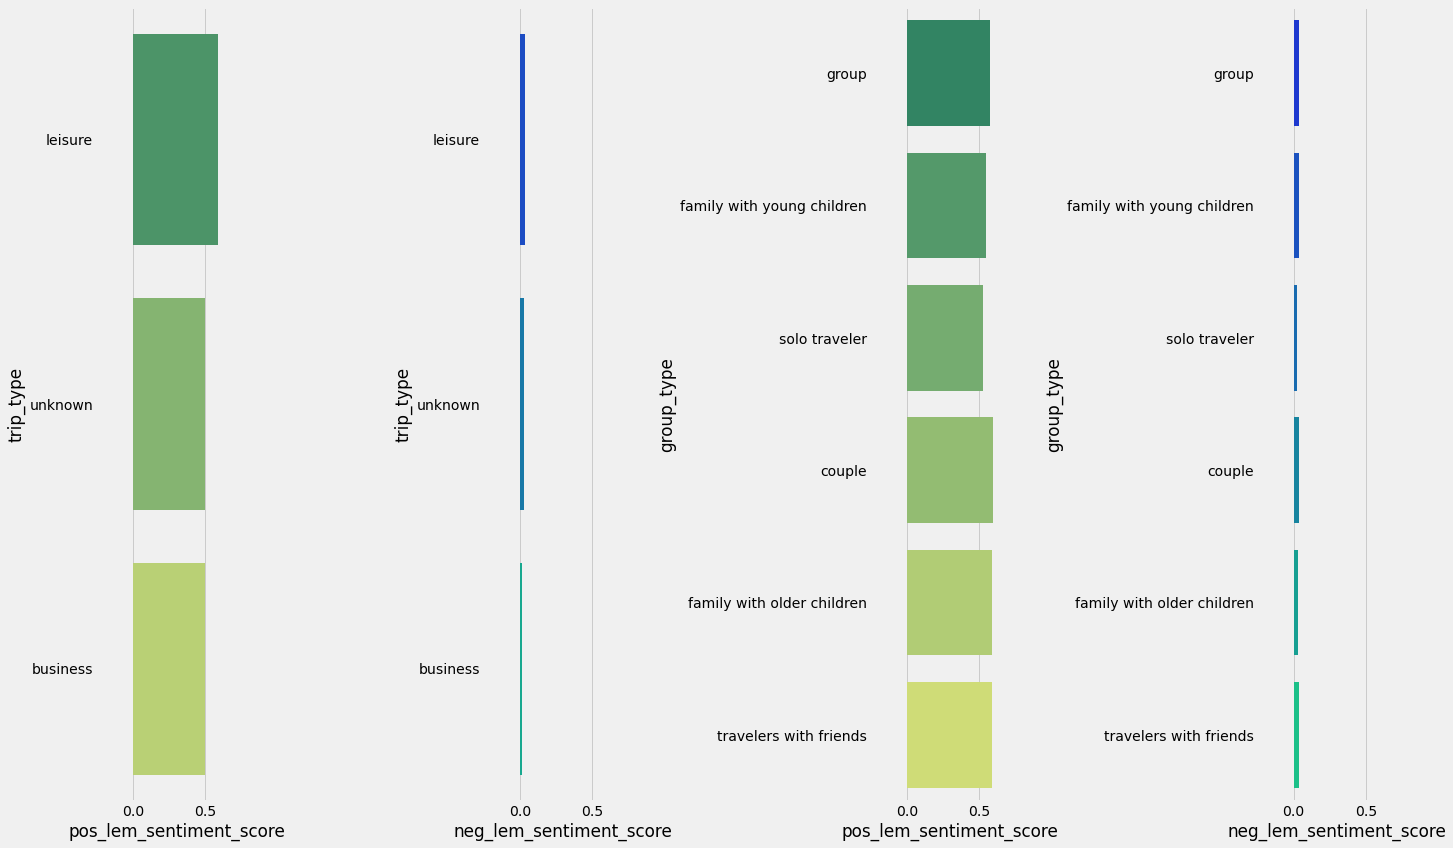

In [22]:
plt.figure(figsize=(20,12))

# Compare trip type and positive sentiment score
plt.subplot(141)
plt.xlim(-.25, .85)
sns.barplot(data=df, y= 'trip_type', x= 'pos_lem_sentiment_score', ci=False, palette='summer')
#plt.show()

# Compare group type and positive sentiment score
plt.subplot(143)
plt.xlim(-.25, .85)
sns.barplot(data=df, y= 'group_type', x= 'pos_lem_sentiment_score', ci= False, palette='summer')

# Compare trip type and negative sentiment score
plt.subplot(142)
plt.xlim(-.25, .85)
sns.barplot(data=df, y= 'trip_type', x= 'neg_lem_sentiment_score', ci=False, palette='winter')

# Compare group type and negative sentiment score
plt.subplot(144)
plt.xlim(-.25, .85)
sns.barplot(data=df, y= 'group_type', x= 'neg_lem_sentiment_score', ci= False, palette='winter')

plt.tight_layout()

<AxesSubplot:xlabel='nps_group', ylabel='neg_lem_sentiment_score'>

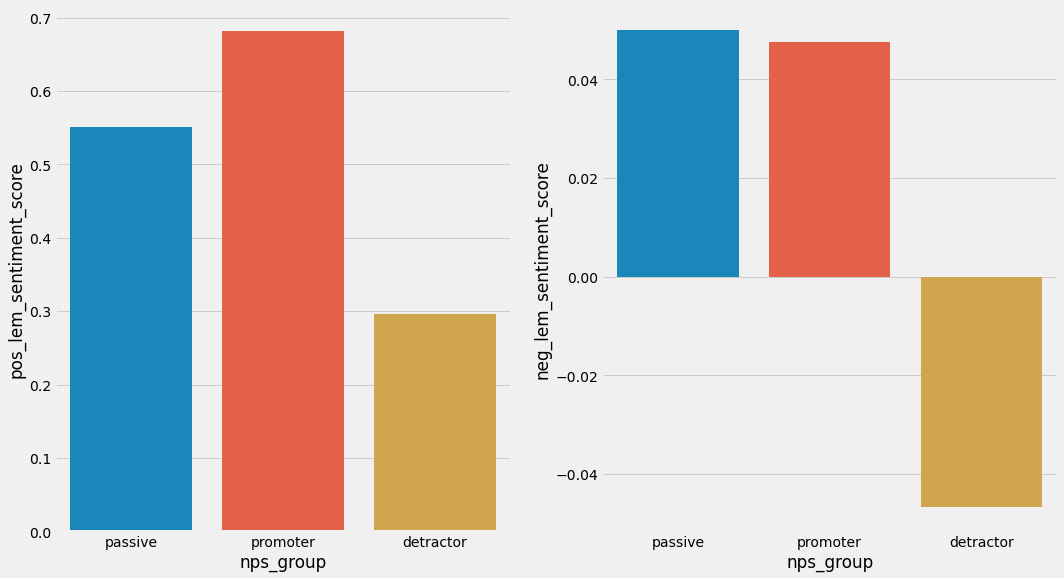

In [21]:
#Compare NPS group and positive sentiment score
plt.figure(figsize=(16,9))

plt.subplot(121)
sns.barplot(data=df, x='nps_group', y='pos_lem_sentiment_score', ci=False)

#Compare NPS group and negative sentiment score
plt.subplot(122)
sns.barplot(data=df, x='nps_group', y='neg_lem_sentiment_score', ci=False)


---

## Topic Modeling 

- For Topic Modeling we used sklearn's Latent Dirichlet Allocation (LDA) model. The LDA model takes each word in the document and assigns it to one of k topics. k is the number of topics set as a hyperparameter in the creation of the LDA model. The model then calculates the proportion of words in the document that are assigned to each topic or $p(topic|document)$. It then calculates the proportion of documents assigned to each topic because of the words in the document or $p(word|topic)$. 

- Pragmatically our process consisted of using the sklearn Count Vectorizer to produce a sparse matrix of token counts from each collection of positive and negative reviews. This sparse matrix was then used as the input for the LDA model and through some data wrangle of the model output we were able to find the top topic for each document as well as the top 15 words for each topic.

- After completing the topic modeling process the resulting dominant topic values for both the positive and negative reviews were saved as a csv and loaded into the notebook. A new categorical feature column was added to the dataframe that denotes the dominant topic for that review.

- The top 15 key words for each of the 10 topic groups for both the negative and positive reviews can be seen below. These key words are paired with the most frequent dominant topic in the hotel specific dataset seen later in this notebook

### LDA Topic Model findings

- Used as a starting point for manual topic model creation

In [23]:
#read in the positive topic keywords csv
pos_keywords = pd.read_csv('positive_topic_keywords.csv')
pos_keywords

,Unnamed: 0,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
0,Topic 0,hotel great location,staff great location,room clean comfortable,hotel good location,room spacious clean,good location close,room comfy bed,helpful staff great,great location staff,good location friendly,staff excellent location,breakfast friendly staff,comfortable staff friendly,great location clean,good staff friendly
1,Topic 1,staff helpful friendly,staff good location,staff really helpful,staff extremely friendly,clean comfortable room,great location close,staff friendly room,location helpful staff,helpful staff good,staff super friendly,comfortable bed good,bed extremely comfortable,great location good,good size room,staff nice helpful
2,Topic 2,staff friendly helpful,staff extremely helpful,room comfortable bed,room good size,friendly helpful room,location great staff,hotel staff friendly,friendly staff clean,close metro station,staff good breakfast,bed really comfortable,location staff friendly,close tube station,easy walking distance,bed comfortable staff
3,Topic 3,friendly helpful staff,good value money,friendly staff good,room friendly staff,location walking distance,clean staff friendly,location friendly helpful,bed super comfy,room good breakfast,great location nice,bed comfy room,breakfast good location,location good breakfast,comfy bed great,excellent value money
4,Topic 4,location friendly staff,helpful friendly staff,great location friendly,friendly staff great,staff really friendly,bed comfortable room,great value money,great location great,hotel friendly staff,location minute walk,room great location,location excellent staff,bed really comfy,staff polite helpful,really friendly helpful


In [24]:
#read in the negative topic keywords csv
neg_keywords = pd.read_csv('negative_topic_keywords.csv')
neg_keywords

,Unnamed: 0,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
0,Topic 0,air conditioning working,room air conditioning,room double bed,took long time,double bed single,room hot air,size room small,coffee machine room,bed single bed,booking com hotel,room small price,single room small,breakfast room small,bottle water room,asked quiet room
1,Topic 1,room little small,breakfast included price,air conditioning work,room little bit,room service menu,room size small,mini bar room,good night sleep,little bit small,small room small,little bit far,bed bit hard,iron ironing board,room booking com,double room small
2,Topic 2,tea coffee facility,coffee facility room,room small bed,room really small,room ground floor,breakfast included room,room smaller expected,poor value money,water pressure shower,ground floor room,non smoking room,hotel booking com,included room rate,small room bathroom,room far small
3,Topic 3,room bit small,coffee making facility,making facility room,tea coffee making,tea coffee room,tea making facility,room extremely small,room small bathroom,good value money,room service food,single bed pushed,room single bed,booked double room,location bit far,like star hotel
4,Topic 4,room quite small,air conditioning room,far city center,booked booking com,air conditioning unit,king size bed,far city centre,room small room,bed little hard,bit far city,hot water shower,booking booking com,room bathroom small,free wifi room,room small people


### Manual Topic Segmentation

- After inconclusive findings from machine learning topic modeling we took insight from those results and created manual topic segments based on human understanding of the context of words used in the review texts. 

- Keyword lists were compiled and manualy created topic labels were programatically assigned to each review set. 

In [25]:
#assign manually identified keywords to topic groups for review classification
staff_words = ['staff','friendly','helpful','reception','maids','attentive','concierge','service','receptionist']    
location_words = ['location','located','view','area','metro','city','central','centre','center','train','access','walk',
                      'public','transport','transportation','downtown','accessible','station','convenient','shop','distance']    
room_words = ['room','bed','matress','bathroom','spacious','shower','suite','pillow','bedroom','conditioning','bathtub','air',
                  'window','conditioned','double','twin','size','single','noise','tv','bath','carpet','tile','noisy','small',
                  'furniture','quiet','toilet']    
facilities_words = ['facilities','breakfast','security','buffet','restaurant','bar','coffee','tea','pool','wifi','facility',
                        'parking','lobby','lounge','drink','hall','corridor','menu','storage','order','dining']   
value_words = ['value','money','cheap','cheapest','expensive','price','priced','cost']    
hotel_words = ['hotel']    
comfort_words = ['comfort','nothing','everything','atmosphere','good','comfortable','uncomfortable','pretty','clean','experience']
#create a datframe that contains the topic title and the keywords associated with that topic
manual_topics = pd.DataFrame()
topics = ['Staff','Locations','Room','Facilities','Value','Hotel','Comfort']
lists = [staff_words,location_words,room_words,facilities_words,value_words,hotel_words,comfort_words]
manual_topics['Topics'] = topics
manual_topics['Words'] = lists
#view and verify the resulting dataframe
manual_topics


,Topics,Words
0,Staff,"[staff, friendly, helpful, reception, maids, a..."
1,Locations,"[location, located, view, area, metro, city, c..."
2,Room,"[room, bed, matress, bathroom, spacious, showe..."
3,Facilities,"[facilities, breakfast, security, buffet, rest..."
4,Value,"[value, money, cheap, cheapest, expensive, pri..."
5,Hotel,[hotel]
6,Comfort,"[comfort, nothing, everything, atmosphere, goo..."


---

## Exploration of Drivers of Reviewer Score by Key Customer Group

#### Group Type = Couples:

- The majority of group type represented in this dataset was couples. Below are counts of customer couples for each of the reviewer groups and the counts of primary review topics for the couples who were detractors and the couple who were promoters.

In [26]:
#subset the dataframe to represent only reviews from group types that were couples
couples = df[df['group_type'] == 'couple']
#view the counts based on nps group
couples.nps_group.value_counts()

promoter     128840
passive       85754
detractor     37700
Name: nps_group, dtype: int64

In [27]:
#further subset the dataframe by the observations that were couples and detractors
detractor_couples = couples[couples['nps_group'] == 'detractor']
#show the top three negative dominant topics
detractor_couples.negative_topic.value_counts()

room          22153
staff          4905
facilities     3504
location       1771
no_topic       1707
hotel          1243
blank          1011
value           870
comfort         536
Name: negative_topic, dtype: int64

In [28]:
#further subset the dataframe by the observations that were couples and promoters
promoter_couples = couples[couples['nps_group'] == 'promoter']
#show the top three positive dominant topics
promoter_couples.positive_topic.value_counts()

staff         51322
location      25509
room          22609
comfort        9017
facilities     7390
no_topic       4954
hotel          3946
blank          3052
value          1034
number            7
Name: positive_topic, dtype: int64

#### Key Findings:
   - 128840 couples provided a reviewer score of 9 or 10 making them a promoter

   - 37,000 couples provided a reviewer score of less than 7 making them a detractor
   
   - The top three positive review topics were staff, location, and room 
   
   - The top three negative review topics were issues with room, staff, or facilities

---

#### Trip Type = Leisure Trip:

- The majority of trip type represented in this dataset was leisure trips. Below are counts of leisure trip customers for each of the reviewer groups and the counts of primary review topics for leisure trip customers who were detractors and leisure trip customers who were promoters.

In [29]:
#subset the dataframe by customers on a leisure trip
leisure_trip = df[df['trip_type'] == 'leisure']
#view customer counts by reviewer/promoter group
leisure_trip.nps_group.value_counts()

promoter     209906
passive      144380
detractor     63492
Name: nps_group, dtype: int64

In [30]:
#further subset to customers who are on a leisure trip and are detrctors
detractor_leisure = leisure_trip[leisure_trip['nps_group'] == 'detractor']
#view the counts of reviews for each negative topic
detractor_leisure.negative_topic.value_counts()

room          36018
staff          9048
facilities     5695
location       3181
no_topic       3091
hotel          2264
blank          1830
value          1433
comfort         932
Name: negative_topic, dtype: int64

In [31]:
#further subset to customers on a leisure trip and who are promoters
promoter_leisure = leisure_trip[leisure_trip['nps_group'] == 'promoter']
#view the counts of reviews for each positive topic
promoter_leisure.positive_topic.value_counts()

staff         84373
location      42105
room          35483
comfort       14971
facilities    11892
no_topic       7979
hotel          6244
blank          5143
value          1710
number            6
Name: positive_topic, dtype: int64

#### Key Findings:
   - 209906 leisure trip customers provided a reviewer score of 9 or 10 making them a promoter

   - 63,492 leisure trip customers provided a reviewer score of less than 7 making them a detractor
   
   - The top three positive review topics were staff, location, and room
   
   - The top three negative review topics were issues with room, staff, and facilities
   

---

#### Nights Stayed = 3 or less

- Most customers in this dataset stayed three or less nights. Below are counts of customers who stayed three or less nights for each of the promoter groups and the counts of primary review topics for customers who stayed three or less nights and were detractors and customers who stayed three or less nights and were promoters.

In [32]:
#subset the dataframe to customers who stayed three or less nights
threel_night = df[df['nights_stayed'] <= 3]
#look at the counts of customers by reviewer/promoter group
threel_night.nps_group.value_counts()

promoter     204510
passive      147863
detractor     71222
Name: nps_group, dtype: int64

In [33]:
#further subset the dataframe to include customers who stayed three or less nights and were detractors
threel_detractor = threel_night[threel_night['nps_group'] == 'detractor']
#view the counts of reviews by negative topic
threel_detractor.negative_topic.value_counts()

room          40695
staff          9846
facilities     6327
no_topic       3670
location       3316
hotel          2484
blank          2103
value          1698
comfort        1082
number            1
Name: negative_topic, dtype: int64

In [34]:
#further subset to include customers who stayed three or less nights and who are promoters
threel_promoter = threel_night[threel_night['nps_group'] == 'promoter']
#view the number of reviews by positive topic
threel_promoter.positive_topic.value_counts()

staff         80417
location      38951
room          36221
comfort       15135
facilities    11679
no_topic       8544
hotel          6227
blank          5439
value          1889
number            8
Name: positive_topic, dtype: int64

#### Key Findings:

- 204510 customers who stayed three or less nights provided a reviewer score greater than 9 making them a promoter

- 71222 customers who stayed three or less nights provided a reviewer score of less than 7 making them a detractor

- The top three positive review topics were staff, location, and room

- The top three negative review topics were issues with room, staff, or facilities

In [35]:
#bring the results from the above positive topic analysis together in a dataframe so 
#proportions of topic counts can be compared across the three main customer groups with visualizations
pos = pd.DataFrame()
pos['topics'] = promoter_couples.positive_topic.value_counts().sort_index().index
pos['couples'] = promoter_couples.positive_topic.value_counts().sort_index().values
pos['leisure_trip'] = promoter_leisure.positive_topic.value_counts().sort_index().values
pos['three_or_less'] = threel_promoter.positive_topic.value_counts().sort_index().values
pos = pos.set_index('topics')
#view and verify results in the dataframe
pos

,couples,leisure_trip,three_or_less
topics,,,
blank,3052,5143,5439
comfort,9017,14971,15135
facilities,7390,11892,11679
hotel,3946,6244,6227
location,25509,42105,38951
no_topic,4954,7979,8544
number,7,6,8
room,22609,35483,36221
staff,51322,84373,80417


Text(0.5, 1.0, 'Positive Review Topics and Largest Customer Subgroups')

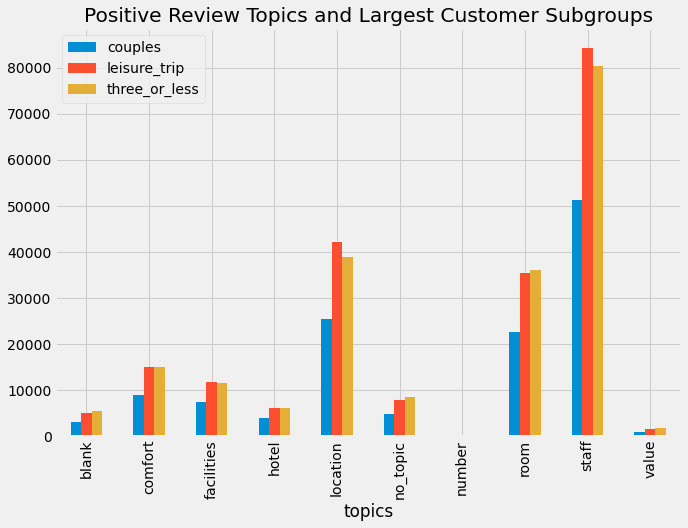

In [36]:
#plot the counts of positive topics by key customer group with a grouped bar chart
pos.plot.bar()
plt.title('Positive Review Topics and Largest Customer Subgroups')

In [37]:
#bring the results from the above negative topic analysis together in a dataframe so 
#proportions of topic counts can be compared across the three main customer groups with visualizations
neg = pd.DataFrame()
neg['topics'] = detractor_couples.negative_topic.value_counts().sort_index().index
neg['couples'] = detractor_couples.negative_topic.value_counts().sort_index().values
neg['leisure_trip'] = detractor_leisure.negative_topic.value_counts().sort_index().values
neg['three_or_less'] = threel_detractor.negative_topic.value_counts().head(9).sort_index().values
neg = neg.set_index('topics')
#view and verify the resulting dataframe
neg

,couples,leisure_trip,three_or_less
topics,,,
blank,1011,1830,2103
comfort,536,932,1082
facilities,3504,5695,6327
hotel,1243,2264,2484
location,1771,3181,3316
no_topic,1707,3091,3670
room,22153,36018,40695
staff,4905,9048,9846
value,870,1433,1698


Text(0.5, 1.0, 'Negative Review Topics vs. Largest Customer Subgroups')

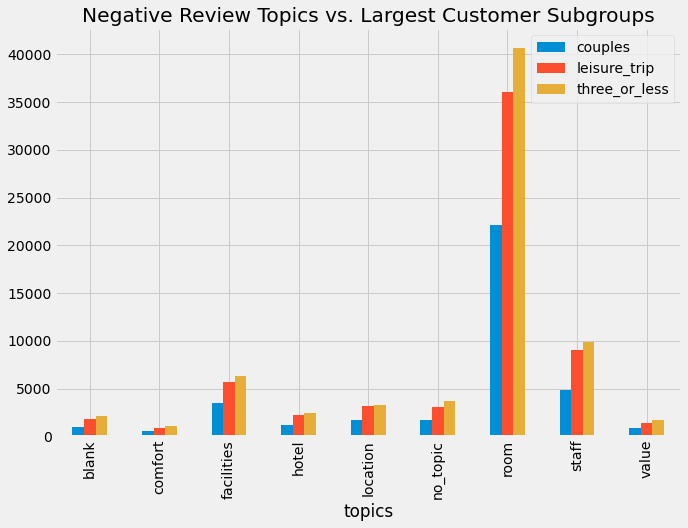

In [38]:
#plot the counts of negative topics by key customer group with a grouped bar chart
neg.plot.bar()
plt.title('Negative Review Topics vs. Largest Customer Subgroups')

---

## Bringing it all together - Sentiment + Topics + Promoter Score + Key Customer Groups

- Below we have visualized all our engineered feature exploration together showing sentiment score by topic for each of the reviewer groups and key customer groups

In [40]:
#subset the dataframe so that it does not include blank reviews, reviews with no topic, 
#or reviews that were identified as a number topic
full_topics = df[
    (df.positive_topic != 'no_topic') & 
    (df.positive_topic != 'blank') & 
    (df.positive_topic != 'number') &
    (df.negative_topic != 'no_topic') & 
    (df.negative_topic != 'blank') & 
    (df.negative_topic != 'number')
    ]

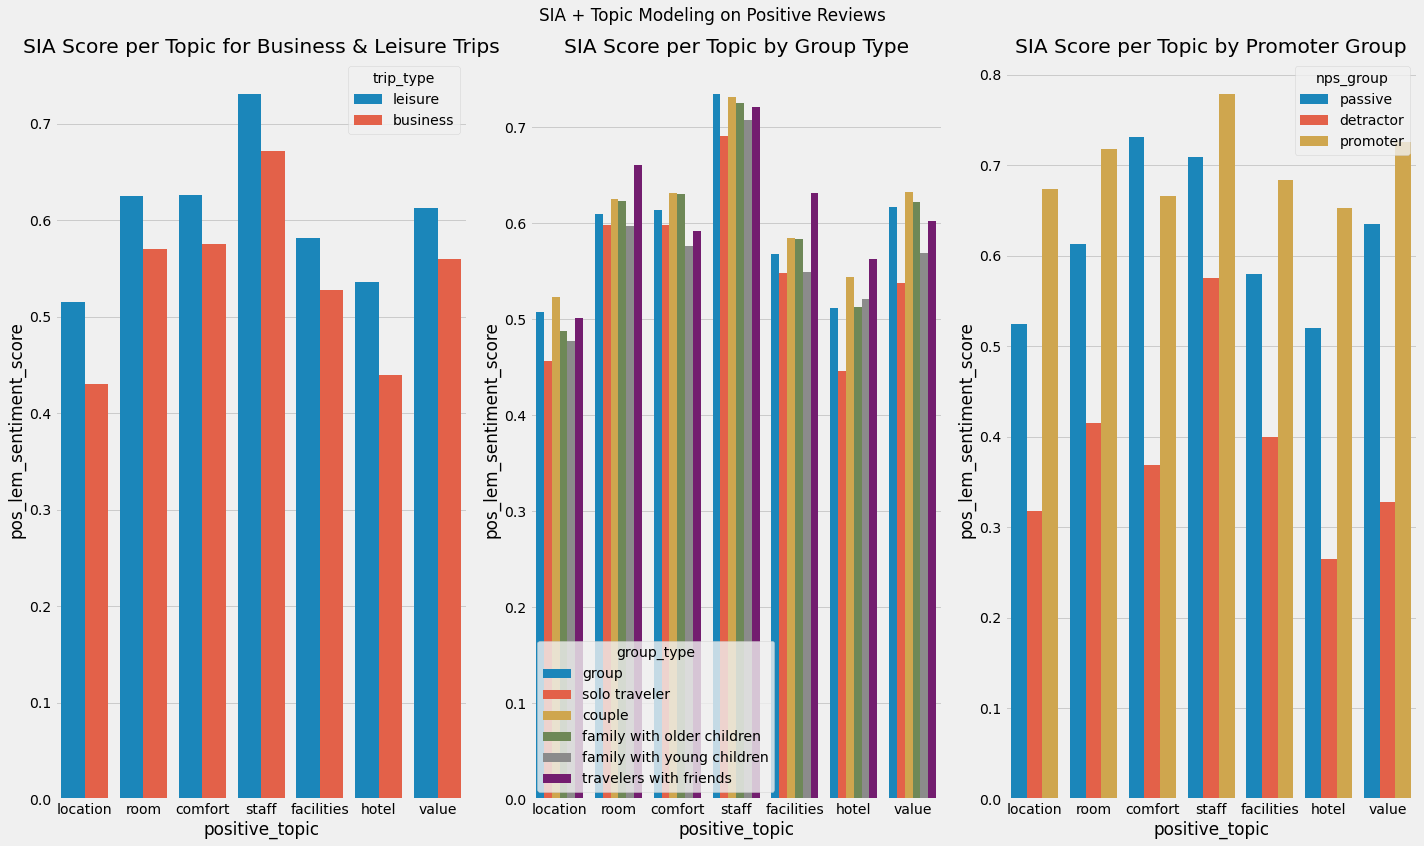

In [41]:
#plot the positive review analysis findings
#create the figure and subplot structure with a title
plt.figure(figsize=(20,12))
plt.suptitle('SIA + Topic Modeling on Positive Reviews')
#Plot the positive sentiment score by topic for each customer trip type in the first subplot area
plt.subplot(131)
sns.barplot(
    data=full_topics[(full_topics.trip_type == 'leisure') | (full_topics.trip_type == 'business')], 
    x='positive_topic', 
    y='pos_lem_sentiment_score', 
    hue='trip_type',
    ci=False)
plt.title('SIA Score per Topic for Business & Leisure Trips')
#plot the positive sentiment score by topic for each of the customer group types in the second subplot area
plt.subplot(132)
sns.barplot(data=full_topics, x='positive_topic', y='pos_lem_sentiment_score', hue='group_type', ci=False)
plt.title('SIA Score per Topic by Group Type')
#plot the positive sentiment scores by topic for each of the customer rating groups in the third subplot area
plt.subplot(133)
sns.barplot(data=full_topics, x='positive_topic', y='pos_lem_sentiment_score', hue='nps_group', ci=False)
plt.title('SIA Score per Topic by Promoter Group')
#view the visualizations in tight layout
plt.tight_layout()

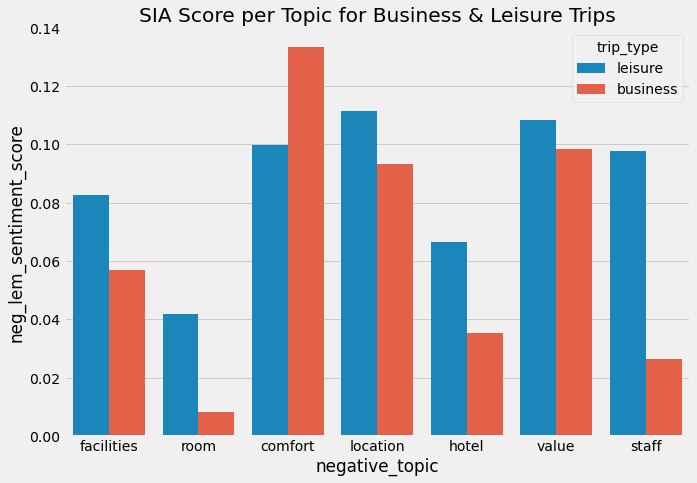

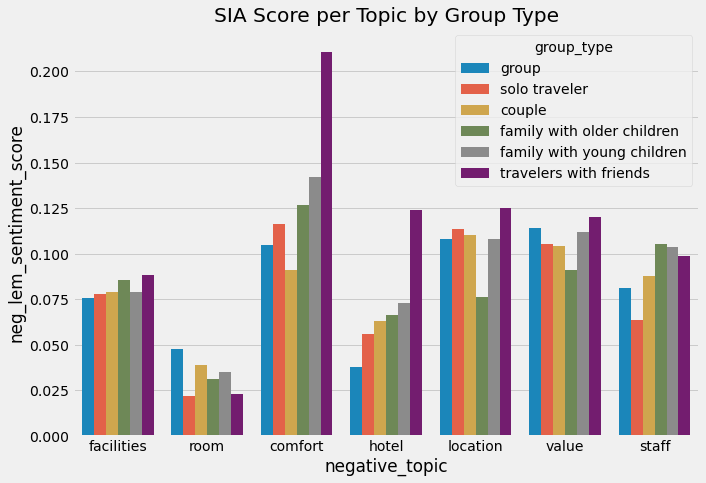

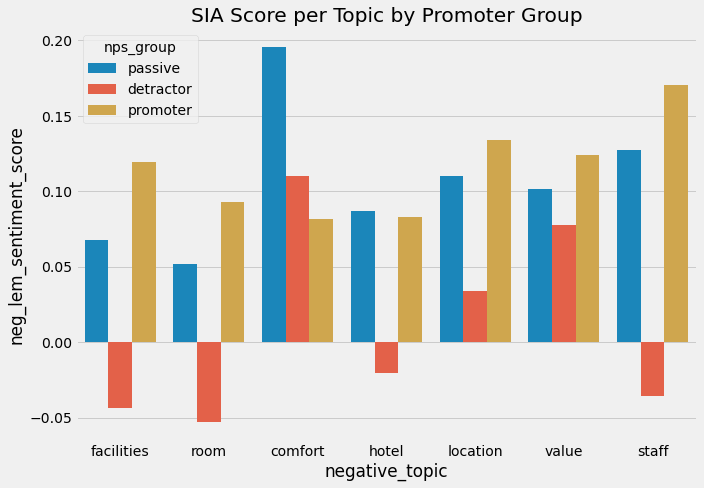

In [42]:
#plot the negative review analysis findings
#Plot the negative sentiment score by topic for each customer trip type in the first visualization
sns.barplot(
    data=full_topics[(full_topics.trip_type == 'leisure') | (full_topics.trip_type == 'business')], 
    x='negative_topic', 
    y='neg_lem_sentiment_score', 
    hue='trip_type',
    ci=False)
plt.title('SIA Score per Topic for Business & Leisure Trips')
plt.show()
#plot the negative sentiment score by topic for each of the customer group types in the second visualization
sns.barplot(data=full_topics, x='negative_topic', y='neg_lem_sentiment_score', hue='group_type', ci=False)
plt.title('SIA Score per Topic by Group Type')
plt.show()
#plot the negative sentiment scores by topic for each of the customer rating groups in the third visualization
sns.barplot(data=full_topics, x='negative_topic', y='neg_lem_sentiment_score', hue='nps_group', ci=False)
plt.title('SIA Score per Topic by Promoter Group')
#view the visualizations in tight layout
plt.tight_layout()

#### Key Takeaways:

- Positive review sentiment scores were skewed towards the positive side for all topics/groups while negative sentiment scores remained overall neutral across topics/groups.

- This finding influenced the use of an NPS style rating to better understand customer opinion while taking into account the possibility of positively skewed review scores.

---

## Summary

- Our primary customer groups include couples, customers on leisure trips, and the majority of our customers stay with us for three or less nights

- The average reviewer score by hotel was 8.47 with a scoring range of 5.12 to 9.73

- Reviewers' scores showed some seasonality with higher scores in the first half of the year (Jan - Jun) and lower scores in the second half of the year (July - dec)

- When grouping reviewers' scores we found that 48% of our customers were *Promoters* scoring their stay with a 9 or 10 and 17% of our customers were *Detractors*, scoring their stay as less than 7.

- When aggregating the score groups following a NPS style rating system we found that the average promoter score for our partner hotels was 34 with a range of (-78 to 93).

- Natural language processing methods were used to identify high frequency words, primary topics and overall sentiment for both positive and negative feedback the customers gave in their reviews.

- The top three positive topics in reviews from our key customer groups included staff, location, and rooms.

- The top three negative topics in reviews from our key customer groups included a prominent focus on issues with the room followed by issues with the staff and the facilities.

- Notable trends were seen in customer groups' sentiment intensity scores on positive reviews, including higher average sentiment from leisure travelers, lower average sentiment from solo travelers and families with young children. Sentiment intensity in negative reviews was mostly neutral for all customer groups except for *Detractors* in the promoter groups. *Detractors*' sentiment intensity scores were consistent with their NPS-style group classification in that they were definitively negative.

- The findings from our analysis has been summarized and loaded into a dashboard where each individual hotel can view their specific statistics as well as the statistics from their neighboring hotels for comparison.

---

## Next Steps

- SHAP sentiment analysis
- Further exploration of manual topic assignment
- Optimize Topic Model hyperparameters
- Number of Topics
- Unigrams, Bigrams, Trigrams
- Different topic modeling algorithms:
- Truncated SVD/Latent Semantic Analysis
- Non-negative Matrix Factorization
- TF-IDF Vectorizer